In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
%matplotlib inline

## Import data and spit into training and testing set


In [4]:
# Load data
df = pd.read_csv('transformed_data.csv', index_col=0, parse_dates=True)
# Convert index to datetime if not already 
df.index = pd.to_datetime(df.index)

# Testing horizon
test_horizon = [30, 90, 180, 252]

## Calculate realized volatililty

In [85]:
# Function to calculate the realized volatility
def realized_volatility(series, window=5):
    return series.rolling(window).std().dropna()

In [37]:
realized_vol_5d = realized_volatility(df['S&P500'], 5)

## Forecasts using GARCH model for each horizon

In [71]:
def fit_garch_model_and_forecast(data, test_horizons):
    """
    Fit GARCH model and generate forecasts for multiple test horizons
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing the S&P500 returns
    test_horizons : list
        List of test horizon periods
    
    Returns:
    --------
    dict : Dictionary containing forecast results for each horizon
    """
    results = {}
    
    # Scale the data by 10 to help with convergence
    scaled_data = data['S&P500'] * 10
    
    for horizon in test_horizons:
        # Split the data
        train = scaled_data[:-horizon]
        test = scaled_data[-horizon:]
        
        # Fit the GARCH model
        model = arch_model(
            train,
            mean="AR",
            lags=1,
            vol='GARCH',
            p=2,
            o=2,
            q=1,
            dist='skewt'
        )
        model_fit = model.fit(disp='off')
        
        # Generate forecast
        forecast = model_fit.forecast(horizon=horizon)
        
        # Store results
        results[horizon] = {
            'forecast': np.sqrt(forecast.variance) / 10,  # Convert to volatility and scale back
        }
    return results

# Fit models and generate forecasts
garch_forecasts = fit_garch_model_and_forecast(df, test_horizon)


for horizon in test_horizon:
    
    
    # Extract first column (h.1 or h.01) for easy access to daily forecasts
    forecast_df = garch_forecasts[horizon]['forecast']
    
    # Create a series with date index for the forecast
    
    forecast_index = df.index[-horizon:]
    
    # Create a Series with first column forecasts and properly aligned dates
    forecast_series = pd.Series(
        forecast_df.iloc[0, :].values, 
        index=forecast_index
    )
    
    # Update forecast in the results
    garch_forecasts[horizon]['forecast'] = forecast_series

print("GARCH forecasts generated for all horizons")





GARCH forecasts generated for all horizons


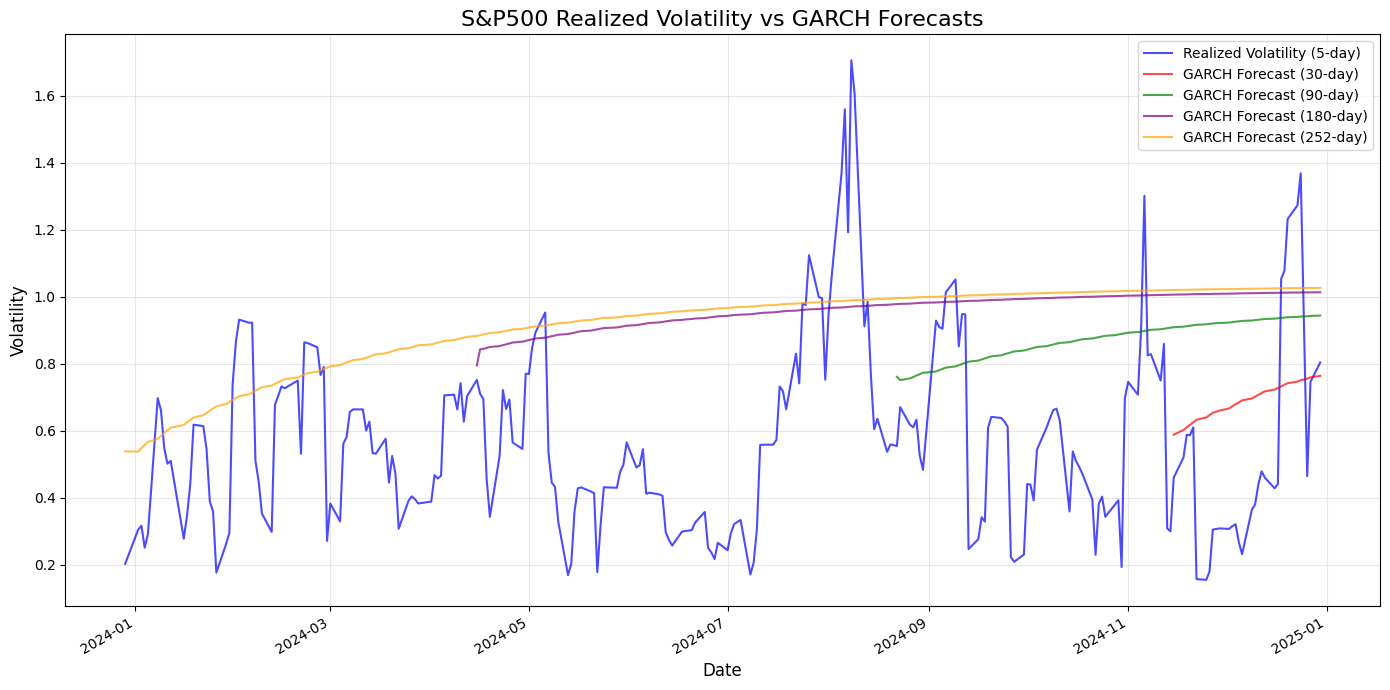

In [73]:
# Create figure
plt.figure(figsize=(14, 7))

# Plot realized volatility - using only available dates
# Get common dates between forecast index and realized_vol_5d index
common_dates = garch_forecasts[test_horizon[-1]]['forecast'].index.intersection(realized_vol_5d.index)
plt.plot(common_dates, realized_vol_5d.loc[common_dates], 
         label='Realized Volatility (5-day)', 
         color='blue', 
         alpha=0.7)

# Plot GARCH forecasts for each horizon with different colors
colors = ['red', 'green', 'purple', 'orange']
for horizon, color in zip(test_horizon, colors):
    forecast = garch_forecasts[horizon]['forecast']
    plt.plot(forecast.index, 
             forecast, 
             label=f'GARCH Forecast ({horizon}-day)', 
             color=color, 
             alpha=0.7)

# Customize plot
plt.title('S&P500 Realized Volatility vs GARCH Forecasts', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

## Rolling Forecast using GARCH model

In [74]:
# Function to perform rolling forecasts with GARCH model
def rolling_forecast_garch(series, window_size, forecast_steps, mean='AR', lags=1, p=2, o=1, q=1, dist='skewt'):
    """
    Perform rolling one-step-ahead GARCH volatility forecasts
    
    Parameters:
    -----------
    series : pd.Series
        Time series data for which to forecast volatility
    window_size : int
        Size of the rolling window used for model estimation
    forecast_steps : int
        Number of one-step-ahead forecasts to make
    mean, lags, p, o, q, dist : model parameters
        Parameters for the GARCH model specification
        
    Returns:
    --------
    pd.Series: Series of one-step-ahead volatility forecasts
    """
    # Ensure we have a pandas Series
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    
    # Prepare container for forecasts
    forecast_dates = series.index[-forecast_steps:]
    forecasts = pd.Series(index=forecast_dates, dtype=float)
    
    # Loop through each forecast period
    for i in range(forecast_steps):
        # Define start and end points for the training window
        end_idx = len(series) - forecast_steps + i
        start_idx = end_idx - window_size
        
        # Slice the training data
        train_data = series.iloc[start_idx:end_idx]
        
        # Create and fit the model on the training window
        model = arch_model(train_data, mean=mean, lags=lags, vol='GARCH', p=p, o=o, q=q, dist=dist)
        model_fit = model.fit(disp='off')
        
        # Generate forecast for the next step
        forecast = model_fit.forecast(horizon=1)
        
        
        # Store the volatility forecast (convert to standard deviation by taking sqrt)
        forecast_date = series.index[end_idx]
        forecasts[forecast_date] = np.sqrt(forecast.variance.iloc[0]['h.1'])
        
        # Print progress if many forecasts
        if forecast_steps > 100 and i % 100 == 0:
            print(f"Completed {i}/{forecast_steps} forecasts")
    
    return forecasts

window_size = 120  


# Dictionary to store rolling forecasts for each horizon
rolling_forecasts = {}

# Run rolling forecast for each horizon
for horizon in test_horizon:
    print(f"Running rolling forecast for {horizon}-day horizon...")
    
    # Calculate how many steps to forecast based on the horizon
    steps_to_forecast = horizon
    
    # Run the rolling forecast
    rolling_forecasts[horizon] = rolling_forecast_garch(
        df['S&P500'], 
        window_size=window_size,
        forecast_steps=steps_to_forecast,
        mean='AR', 
        lags=1,
        p=2, 
        o=2, 
        q=1, 
        dist='skewt'
    )
    
    print(f"Completed {horizon}-day rolling forecast")





Running rolling forecast for 30-day horizon...
Completed 30-day rolling forecast
Running rolling forecast for 90-day horizon...
Completed 90-day rolling forecast
Running rolling forecast for 180-day horizon...
Completed 0/180 forecasts
Completed 100/180 forecasts
Completed 180-day rolling forecast
Running rolling forecast for 252-day horizon...
Completed 0/252 forecasts
Completed 100/252 forecasts
Completed 200/252 forecasts
Completed 252-day rolling forecast


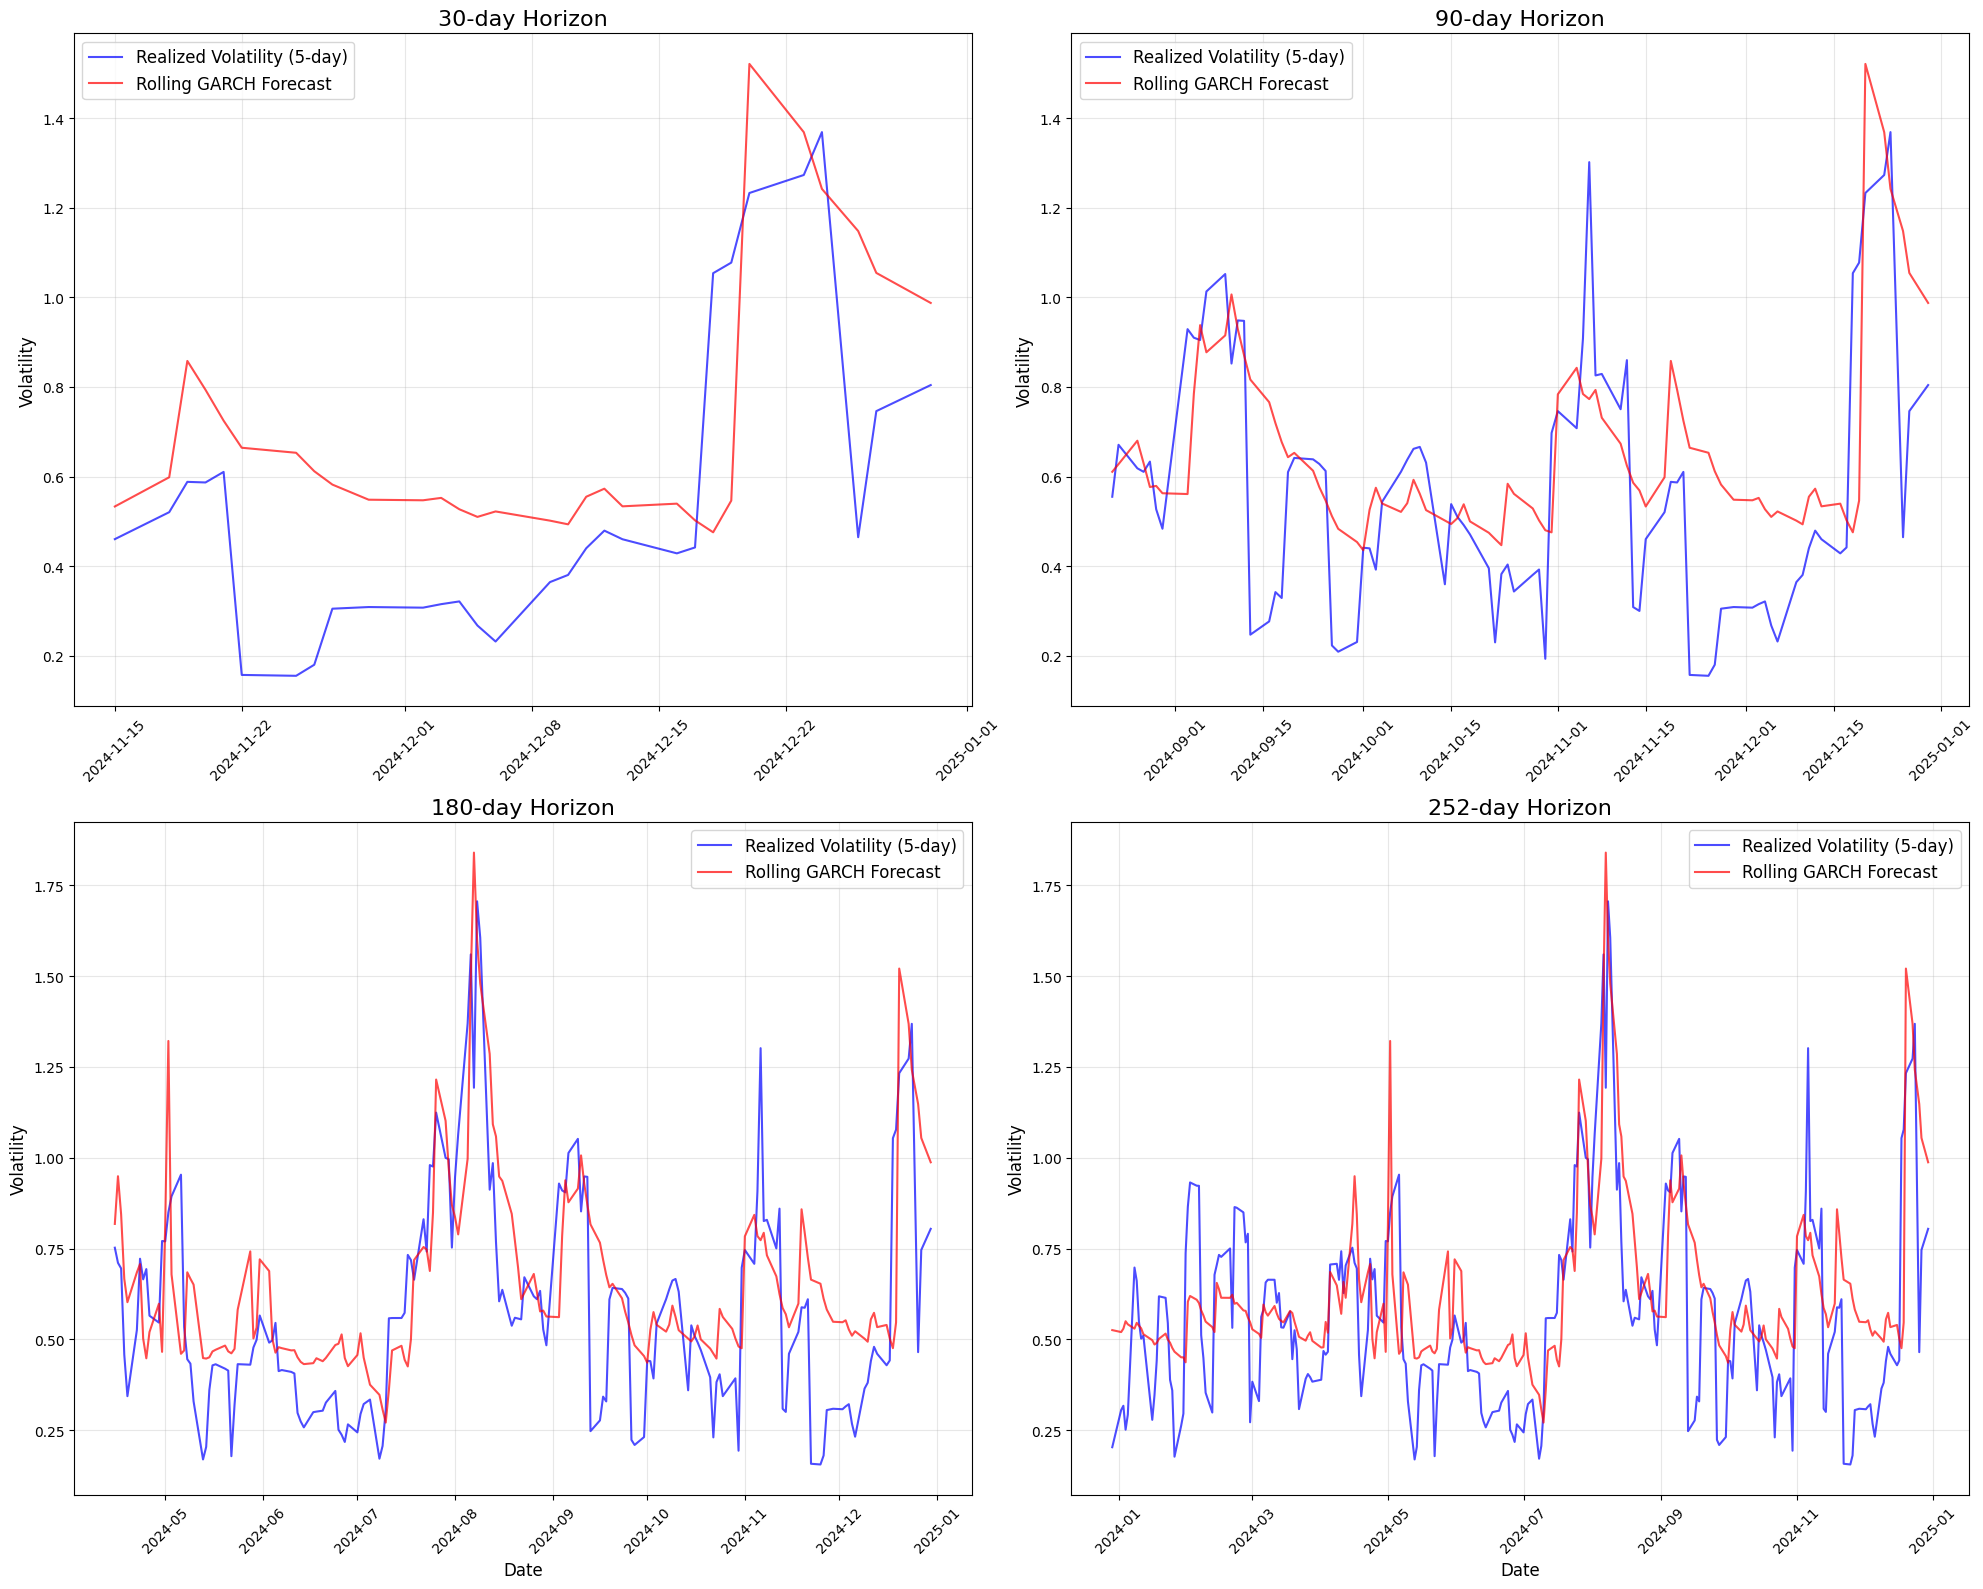

In [75]:
# Create a figure with 4 subplots, one for each horizon
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

# For each horizon, plot the rolling forecast against realized volatility
for i, horizon in enumerate(test_horizon):
    ax = axes[i]
    
    # Get the forecast for this horizon
    forecast = rolling_forecasts[horizon]
    
    # Find common dates between forecast and realized volatility
    common_dates = forecast.index.intersection(realized_vol_5d.index)
    
    # Plot realized volatility
    ax.plot(common_dates, realized_vol_5d.loc[common_dates], 
            label='Realized Volatility (5-day)', 
            color='blue', 
            alpha=0.7)
    
    # Plot rolling forecast
    ax.plot(forecast.index, forecast, 
            label=f'Rolling GARCH Forecast', 
            color='red', 
            alpha=0.7)
    
    # Add title and labels
    ax.set_title(f'{horizon}-day Horizon', fontsize=16)
    ax.set_ylabel('Volatility', fontsize=12)
    if i >= 2:  # Only add xlabel for bottom row plots
        ax.set_xlabel('Date', fontsize=12)
    
    # Add legend and grid
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [114]:
# Create a dictionary to store model results and residuals
results = {}

# Scale the data by 10 to help with convergence issues
scaled_df = df * 10

# For series 1 (S&P500): gjrGARCH(2,1) with ARMA(1,0) and sstd distribution
model_sp500 = arch_model(
    scaled_df['S&P500'], 
    mean="AR", 
    lags=1, 
    vol='GARCH', 
    p=2, 
    o=2, 
    q=1, 
    dist='skewt'
)
results['S&P500'] = {}
model_fit = model_sp500.fit(disp='off')
results['S&P500']['model'] = model_fit
results['S&P500']['residuals'] = model_fit.resid / 10  # Scale back
results['S&P500']['conditional_volatility'] = model_fit.conditional_volatility / 10  # Scale back

# For series 2 (Treasury_30y_10y_Spread): gjrGARCH(1,1) with ARMA(1,0) and sstd distribution
model_treasury = arch_model(
    scaled_df['Treasury_30y_10y_Spread'], 
    mean="AR", 
    lags=1, 
    vol='GARCH', 
    p=1, 
    o=1, 
    q=1, 
    dist='skewt'
)
results['Treasury_30y_10y_Spread'] = {}
model_fit = model_treasury.fit(disp='off')
results['Treasury_30y_10y_Spread']['model'] = model_fit
results['Treasury_30y_10y_Spread']['residuals'] = model_fit.resid / 10  # Scale back
results['Treasury_30y_10y_Spread']['conditional_volatility'] = model_fit.conditional_volatility / 10  # Scale back

# For series 3 (VIX): gjrGARCH(2,2) with ARMA(1,1) and sstd distribution
model_vix = arch_model(
    scaled_df['VIX'], 
    mean="AR", 
    lags=1, 
    vol='GARCH', 
    p=2, 
    o=2, 
    q=2, 
    dist='skewt'
)
results['VIX'] = {}
model_fit = model_vix.fit(disp='off')
results['VIX']['model'] = model_fit
results['VIX']['residuals'] = model_fit.resid / 10  # Scale back
results['VIX']['conditional_volatility'] = model_fit.conditional_volatility / 10  # Scale back


# LSTM modeling

In [87]:
df.columns

Index(['S&P500', 'Treasury_30y_10y_Spread', 'VIX'], dtype='object')

In [ ]:


def create_lstm_features(df):
    """
    Create features for LSTM model using S&P500 realized volatility,
    Treasury spread realized volatility, and VIX.

    Parameters:
    -----------
    df: DataFrame with original data (including VIX)
    realized_vol_sp500: Series with realized volatility of S&P500
    realized_vol_spread: Series with realized volatility of Treasury spread

    Returns:
    --------
    DataFrame: DataFrame with LSTM features, scaled using MinMaxScaler
    """

    # Create a DataFrame to hold the features
    lstm_features = pd.DataFrame(index=df.index)

    # Add realized volatility of S&P500
    lstm_features['realized_vol_sp500'] = realized_volatility(df['S&P500'])

    # Add realized volatility of Treasury spread
    lstm_features['realized_vol_spread'] = realized_volatility(df['Treasury_30y_10y_Spread'])

    # Add VIX
    lstm_features['VIX'] = df['VIX']

    # Drop rows with any missing values
    lstm_features = lstm_features.dropna()


    return lstm_features

In [117]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Input
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def train_lstm_cpcv(features, target, forecast_steps, epochs=20, batch_size=32, n_splits=5):
    """
    Train an LSTM model using Cross-Predictability Component Validation (CPCV) for hyperparameter tuning.
    Returns forecasts for the last 'forecast_steps' points in the dataset.
    
    Parameters and other docstring elements remain the same...
    """
    # Align features and target by index
    common_index = features.index.intersection(target.index)
    features = features.loc[common_index]
    target = target.loc[common_index]

    # Scale the features
    scaler_features = MinMaxScaler()
    features_scaled = scaler_features.fit_transform(features)
    features = pd.DataFrame(features_scaled, index=features.index, columns=features.columns)

    # Scale the target variable
    scaler_target = MinMaxScaler()
    target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))
    
    # Split data to keep last forecast_steps for testing
    train_size = len(features) - forecast_steps
    
    # Prepare data for LSTM - use all data except the last forecast_steps points
    X, y = [], []
    for i in range(train_size):
        X.append(features.iloc[i].values)
        y.append(target_scaled[i])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshape to be [samples, time steps, features]

    # TimeSeriesSplit cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Initialize lists to store metrics
    rmse_scores = []

    # Cross validation part remains the same...
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Define LSTM model - remains the same...
        model = Sequential([
            Input(shape=(1, features.shape[1])),
            LSTM(128, return_sequences=True, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(64, activation='relu'),
            LSTM(64, return_sequences=True, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(32, activation='relu'),
            LSTM(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')

        # Train model - remains the same...
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                           validation_data=(X_val, y_val), verbose=0, shuffle=False)

        # Evaluate model on validation data
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # Train final model on all training data
    model = Sequential([
        Input(shape=(1, features.shape[1])),
        LSTM(128, return_sequences=True, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu'),
        LSTM(64, return_sequences=True, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        LSTM(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
    
    # Prepare test data - the last forecast_steps points
    X_test = []
    for i in range(train_size, len(features)):
        X_test.append(features.iloc[i].values)
    X_test = np.array(X_test)
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    # Generate forecasts for test data
    forecasts = model.predict(X_test)
    
    # Inverse transform the predictions
    forecasts = scaler_target.inverse_transform(forecasts)
    
    # Get actual values for comparison (optional)
    y_test = target_scaled[train_size:].reshape(-1, 1)
    y_test_inv = scaler_target.inverse_transform(y_test)

    return model, forecasts, history, rmse_scores, y_test_inv  # Added actual values for comparison

In [ ]:
# Create LSTM features
lstm_features = create_lstm_features(df)

# Set the target variable
target = lstm_features['realized_vol_sp500']

# Drop target from features
lstm_features = lstm_features.drop('realized_vol_sp500', axis=1)

for horizon in test_horizon:
    print(f"Running LSTM model for {horizon}-day horizon...")
    
    # Train LSTM model  
    model, forecasts, history, rmse_scores, y_test_inv = train_lstm_cpcv(
        lstm_features, 
        target, 
        forecast_steps=horizon, 
        epochs=20, 
        batch_size=32, 
        n_splits=5
    )

    results[f'LSTM_{horizon}'] = {
        'model': model,
        'forecasts': forecasts,
        'history': history,
        'rmse_scores': rmse_scores}
    
    print(f"Completed {horizon}-day LSTM model")




Running LSTM model for 30-day horizon...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
Completed 30-day LSTM model
Running LSTM model for 90-day horizon...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
Completed 90-day LSTM model
Running LSTM model for 180-day horizon...
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Completed 180-day LSTM model
Running LSTM model for 252-day horizon...
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19m

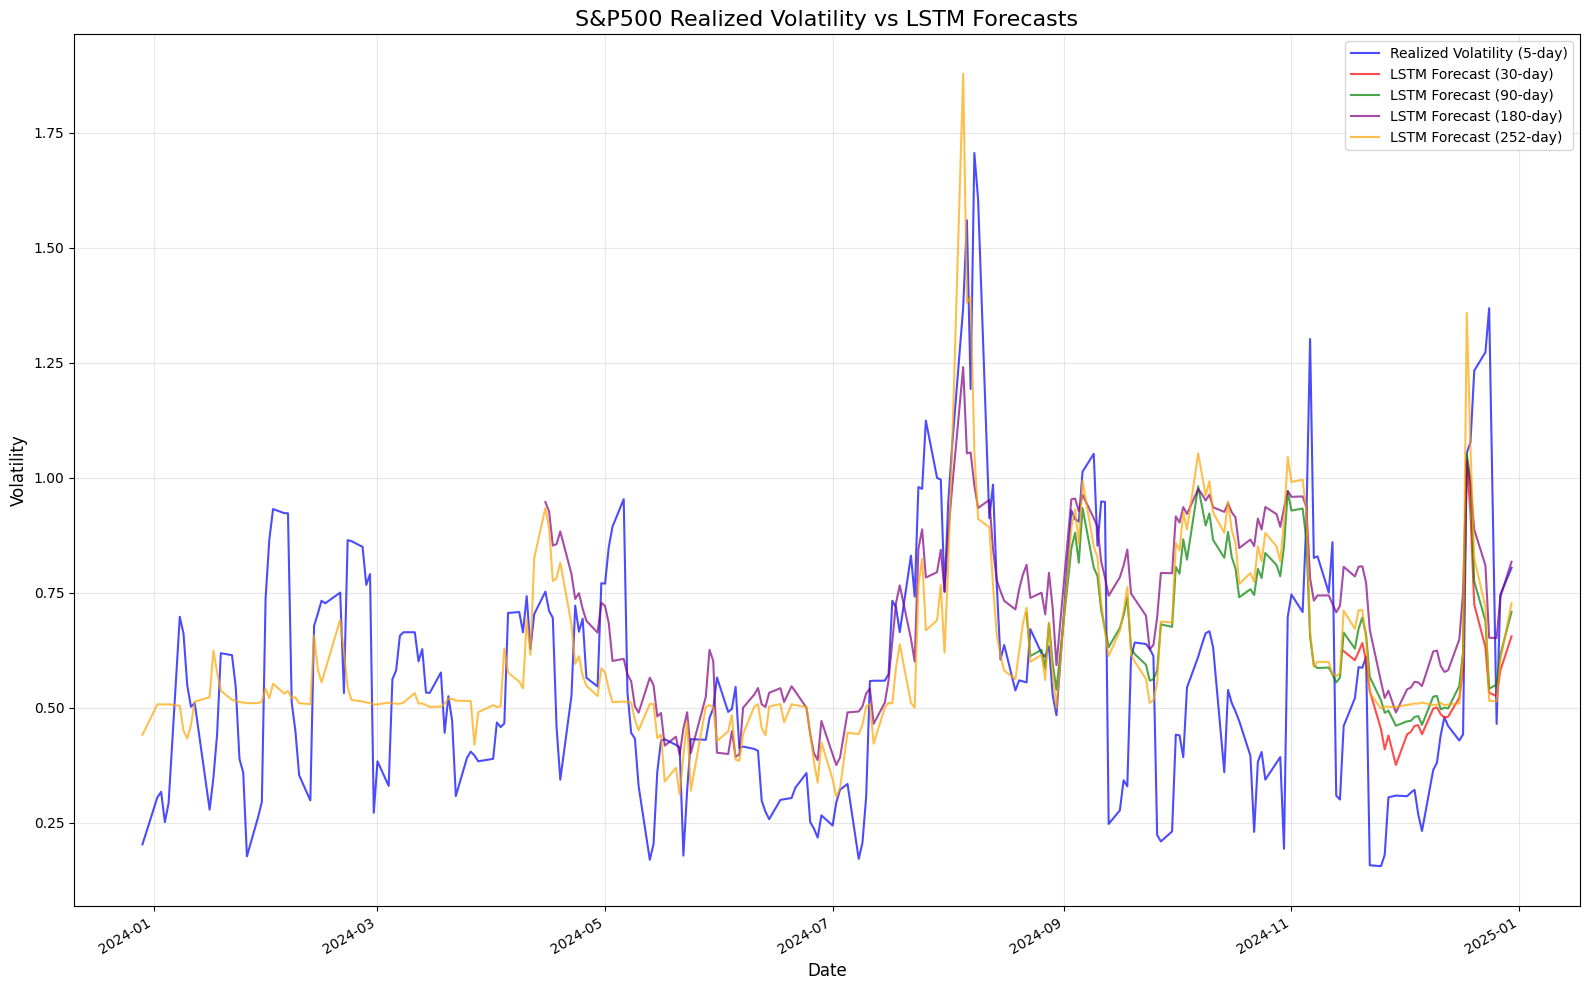

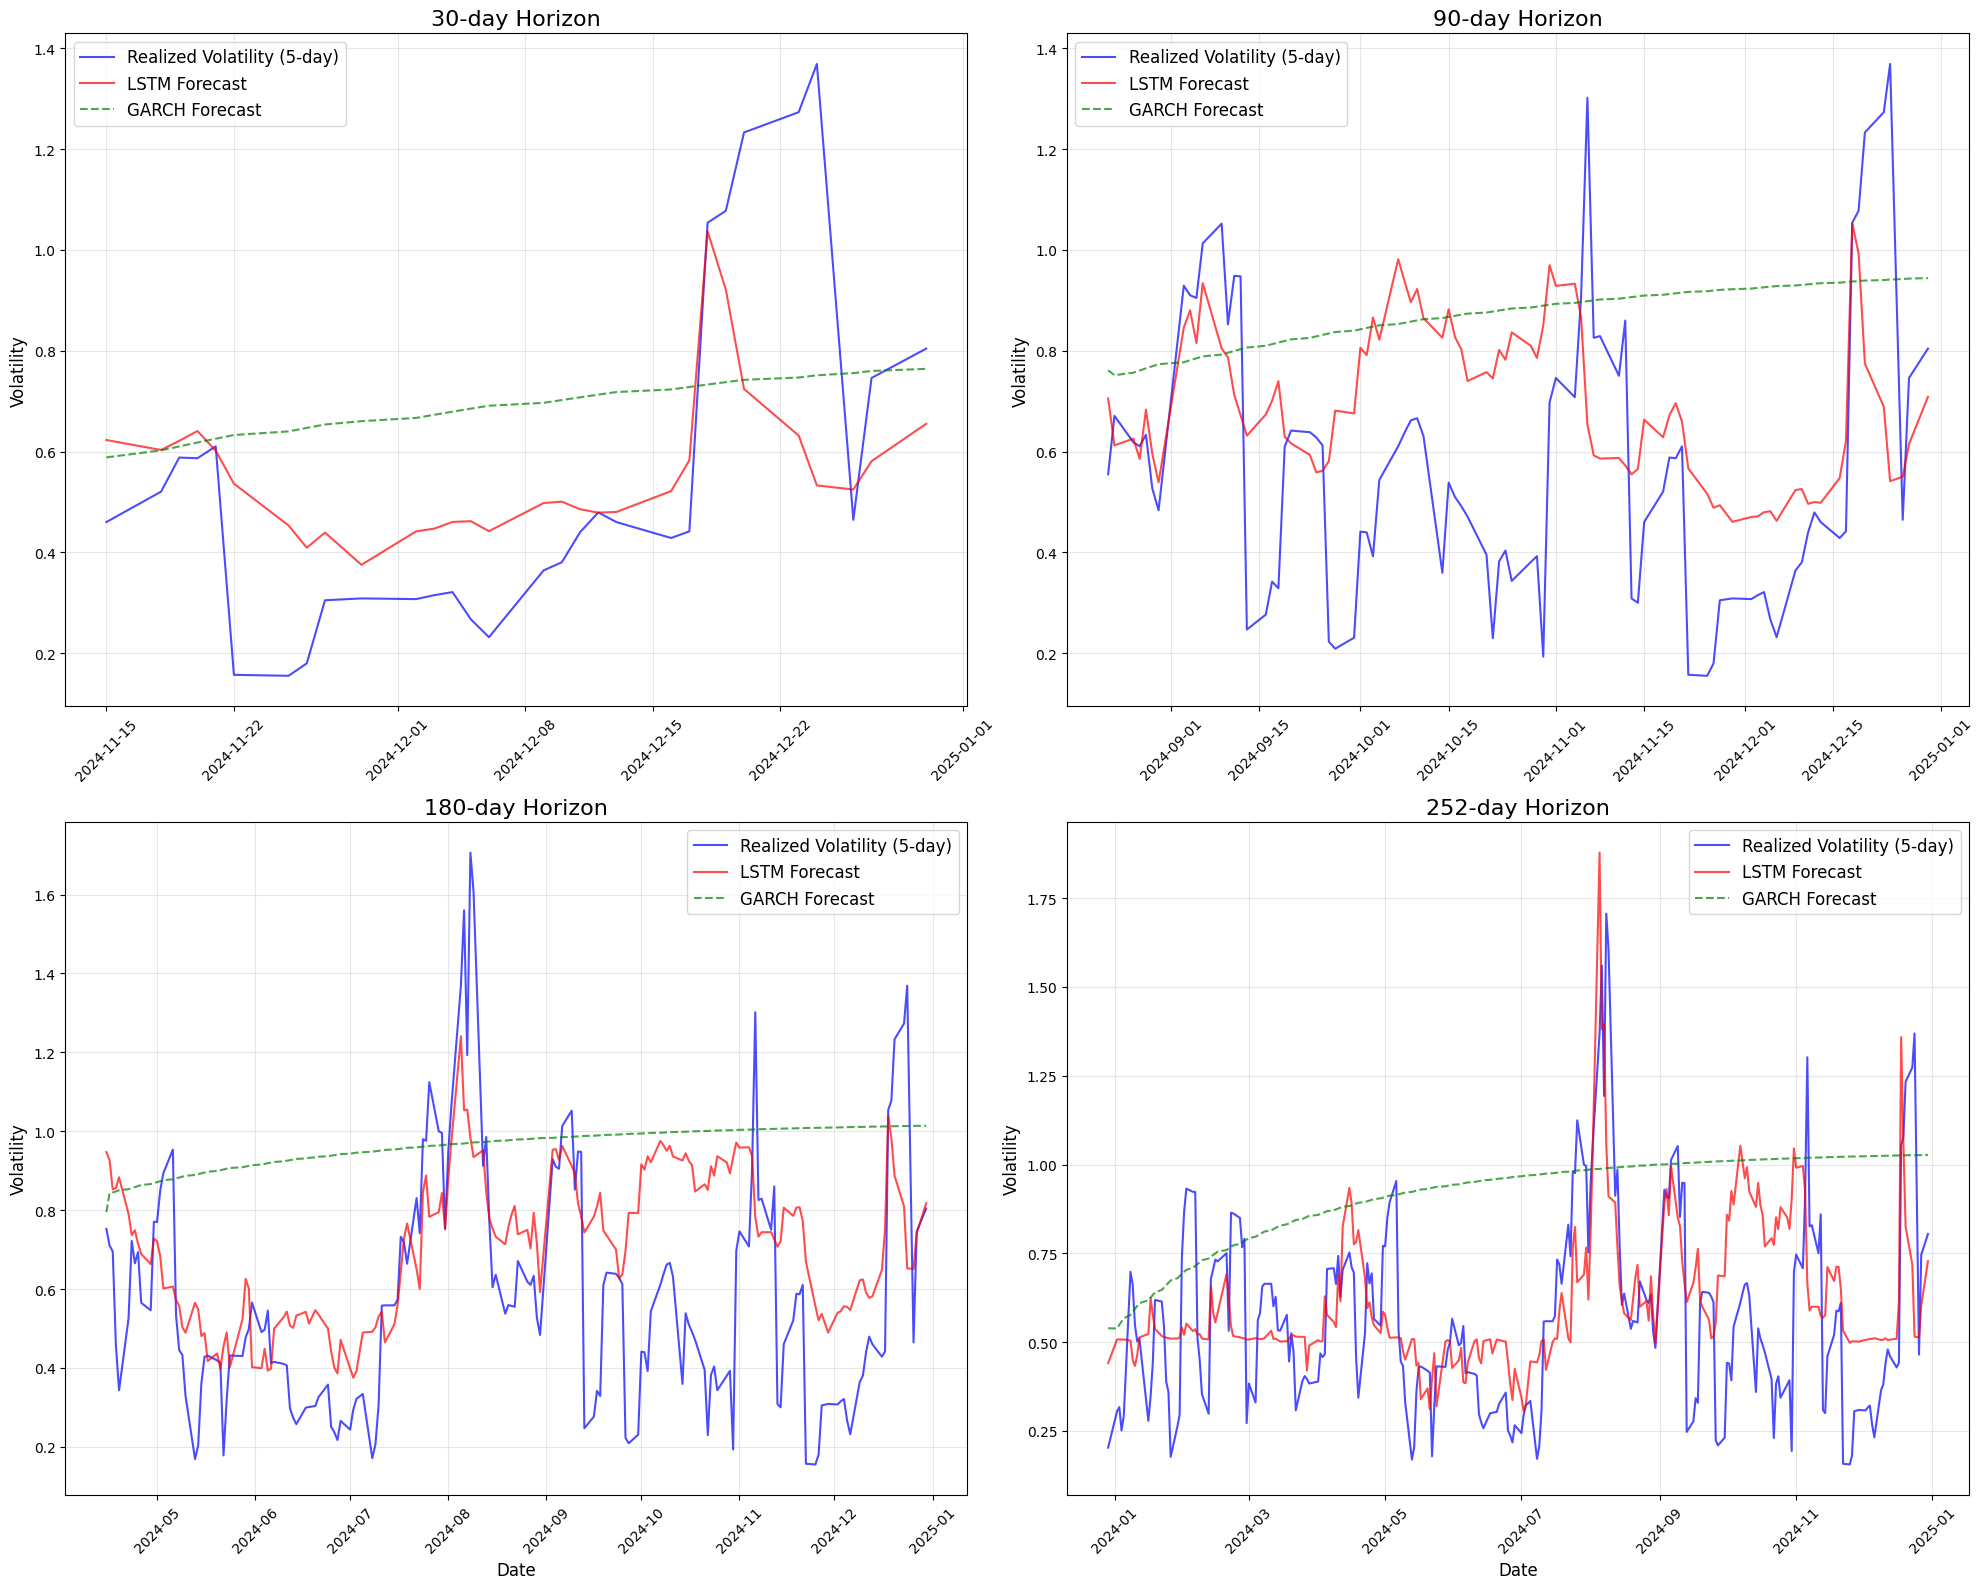

In [111]:
# Create figure for LSTM forecasts comparison
plt.figure(figsize=(16, 10))

# Get realized volatility
plt.plot(realized_vol_5d.index[-252:], realized_vol_5d.iloc[-252:], 
         label='Realized Volatility (5-day)', 
         color='blue', 
         alpha=0.7)

# Plot LSTM forecasts for each horizon with different colors
colors = ['red', 'green', 'purple', 'orange']
for horizon, color in zip(test_horizon, colors):
    # Format forecast data properly
    forecast_data = results[f'LSTM_{horizon}']['forecasts'].flatten()
    
    # Get appropriate index for this forecast horizon
    forecast_index = df.index[-horizon:]
    
    # Create a Series with forecasts
    forecast_series = pd.Series(forecast_data, index=forecast_index)
    
    # Plot the forecast
    plt.plot(forecast_index, 
             forecast_series, 
             label=f'LSTM Forecast ({horizon}-day)', 
             color=color, 
             alpha=0.7)

# Customize plot
plt.title('S&P500 Realized Volatility vs LSTM Forecasts', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Create a figure with 4 subplots to compare LSTM vs GARCH
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

# For each horizon, plot both models against realized volatility
for i, horizon in enumerate(test_horizon):
    ax = axes[i]
    
    # Get forecast index
    forecast_index = df.index[-horizon:]
    
    # Get LSTM forecast for this horizon
    lstm_forecast = pd.Series(
        results[f'LSTM_{horizon}']['forecasts'].flatten(), 
        index=forecast_index
    )
    
    # Get GARCH forecast for this horizon
    garch_forecast = garch_forecasts[horizon]['forecast']
    
    # Find common dates between forecasts and realized volatility
    common_dates = forecast_index.intersection(realized_vol_5d.index)
    
    # Plot realized volatility
    ax.plot(common_dates, realized_vol_5d.loc[common_dates], 
            label='Realized Volatility (5-day)', 
            color='blue', 
            alpha=0.7)
    
    # Plot LSTM forecast
    ax.plot(lstm_forecast.index, lstm_forecast, 
            label='LSTM Forecast', 
            color='red', 
            linestyle='-', 
            alpha=0.7)
    
    # Plot GARCH forecast
    ax.plot(garch_forecast.index, garch_forecast, 
            label='GARCH Forecast', 
            color='green', 
            linestyle='--', 
            alpha=0.7)
    
    # Add title and labels
    ax.set_title(f'{horizon}-day Horizon', fontsize=16)
    ax.set_ylabel('Volatility', fontsize=12)
    if i >= 2:  # Only add xlabel for bottom row plots
        ax.set_xlabel('Date', fontsize=12)
    
    # Add legend and grid
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# LSTM-GARCH

In [120]:
def create_lstm_features(df, results):
    """
    Create features for LSTM model using S&P500 realized volatility,
    Treasury spread realized volatility, VIX, and conditional volatilities from GARCH models.

    Parameters:
    -----------
    df: DataFrame with original data (including VIX)
    results: Dictionary containing GARCH model results

    Returns:
    --------
    DataFrame: DataFrame with LSTM features, scaled using MinMaxScaler
    """

    # Create a DataFrame to hold the features
    lstm_features = pd.DataFrame(index=df.index)

    # Add realized volatility of S&P500
    lstm_features['realized_vol_sp500'] = realized_volatility(df['S&P500'])

    # Add realized volatility of Treasury spread
    lstm_features['realized_vol_spread'] = realized_volatility(df['Treasury_30y_10y_Spread'])

    # Add VIX
    lstm_features['VIX'] = df['VIX']

    # Add conditional volatilities from GARCH models
    lstm_features['cond_vol_sp500'] = results['S&P500']['conditional_volatility']
    lstm_features['cond_vol_treasury'] = results['Treasury_30y_10y_Spread']['conditional_volatility']
    lstm_features['cond_vol_vix'] = results['VIX']['conditional_volatility']

    # Drop rows with any missing values
    lstm_features = lstm_features.dropna()

    return lstm_features

In [121]:
# Create LSTM features
lstm_features = create_lstm_features(df, results)

# Set the target variable
target = lstm_features['realized_vol_sp500']

# Drop target from features
lstm_features = lstm_features.drop('realized_vol_sp500', axis=1)

for horizon in test_horizon:
    print(f"Running LSTM_GARCH model for {horizon}-day horizon...")
    
    # Train LSTM model  
    model, forecasts, history, rmse_scores, y_test_inv = train_lstm_cpcv(
        lstm_features, 
        target, 
        forecast_steps=horizon, 
        epochs=20, 
        batch_size=32, 
        n_splits=5
    )

    results[f'LSTM_GARCH{horizon}'] = {
        'model': model,
        'forecasts': forecasts,
        'history': history,
        'rmse_scores': rmse_scores}
    
    print(f"Completed {horizon}-day LSTM model")




Running LSTM_GARCH model for 30-day horizon...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
Completed 30-day LSTM model
Running LSTM_GARCH model for 90-day horizon...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
Completed 90-day LSTM model
Running LSTM_GARCH model for 180-day horizon...
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
Completed 180-day LSTM model
Running LSTM_GARCH model for 252-day horizon...
23/23 ━━━

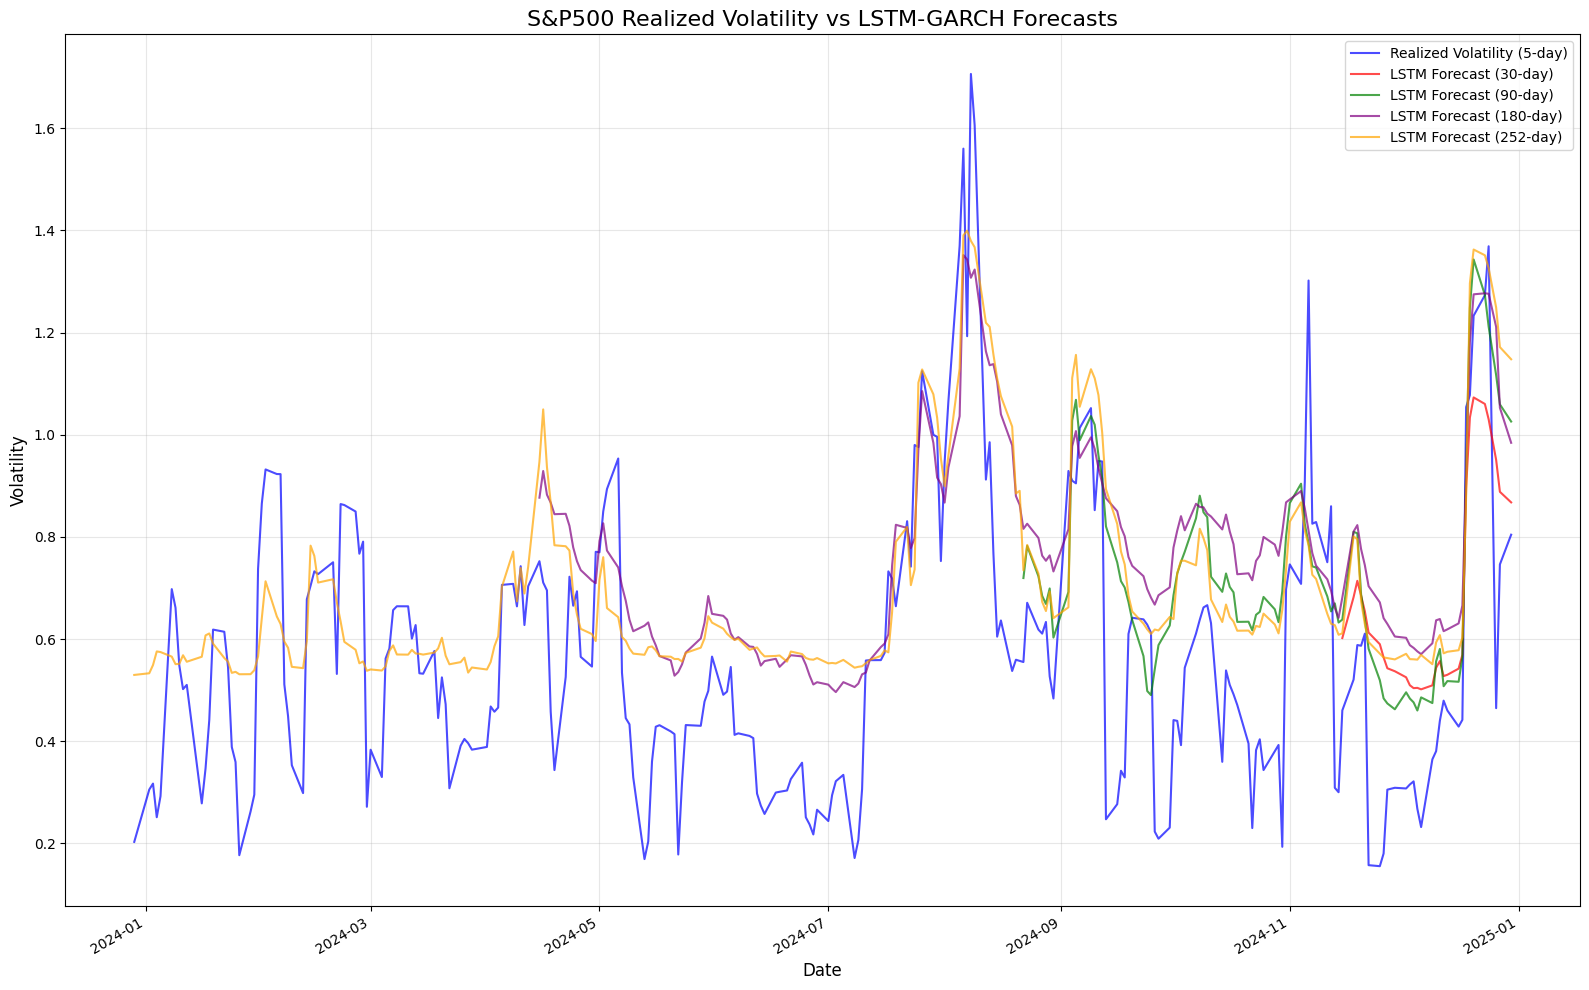

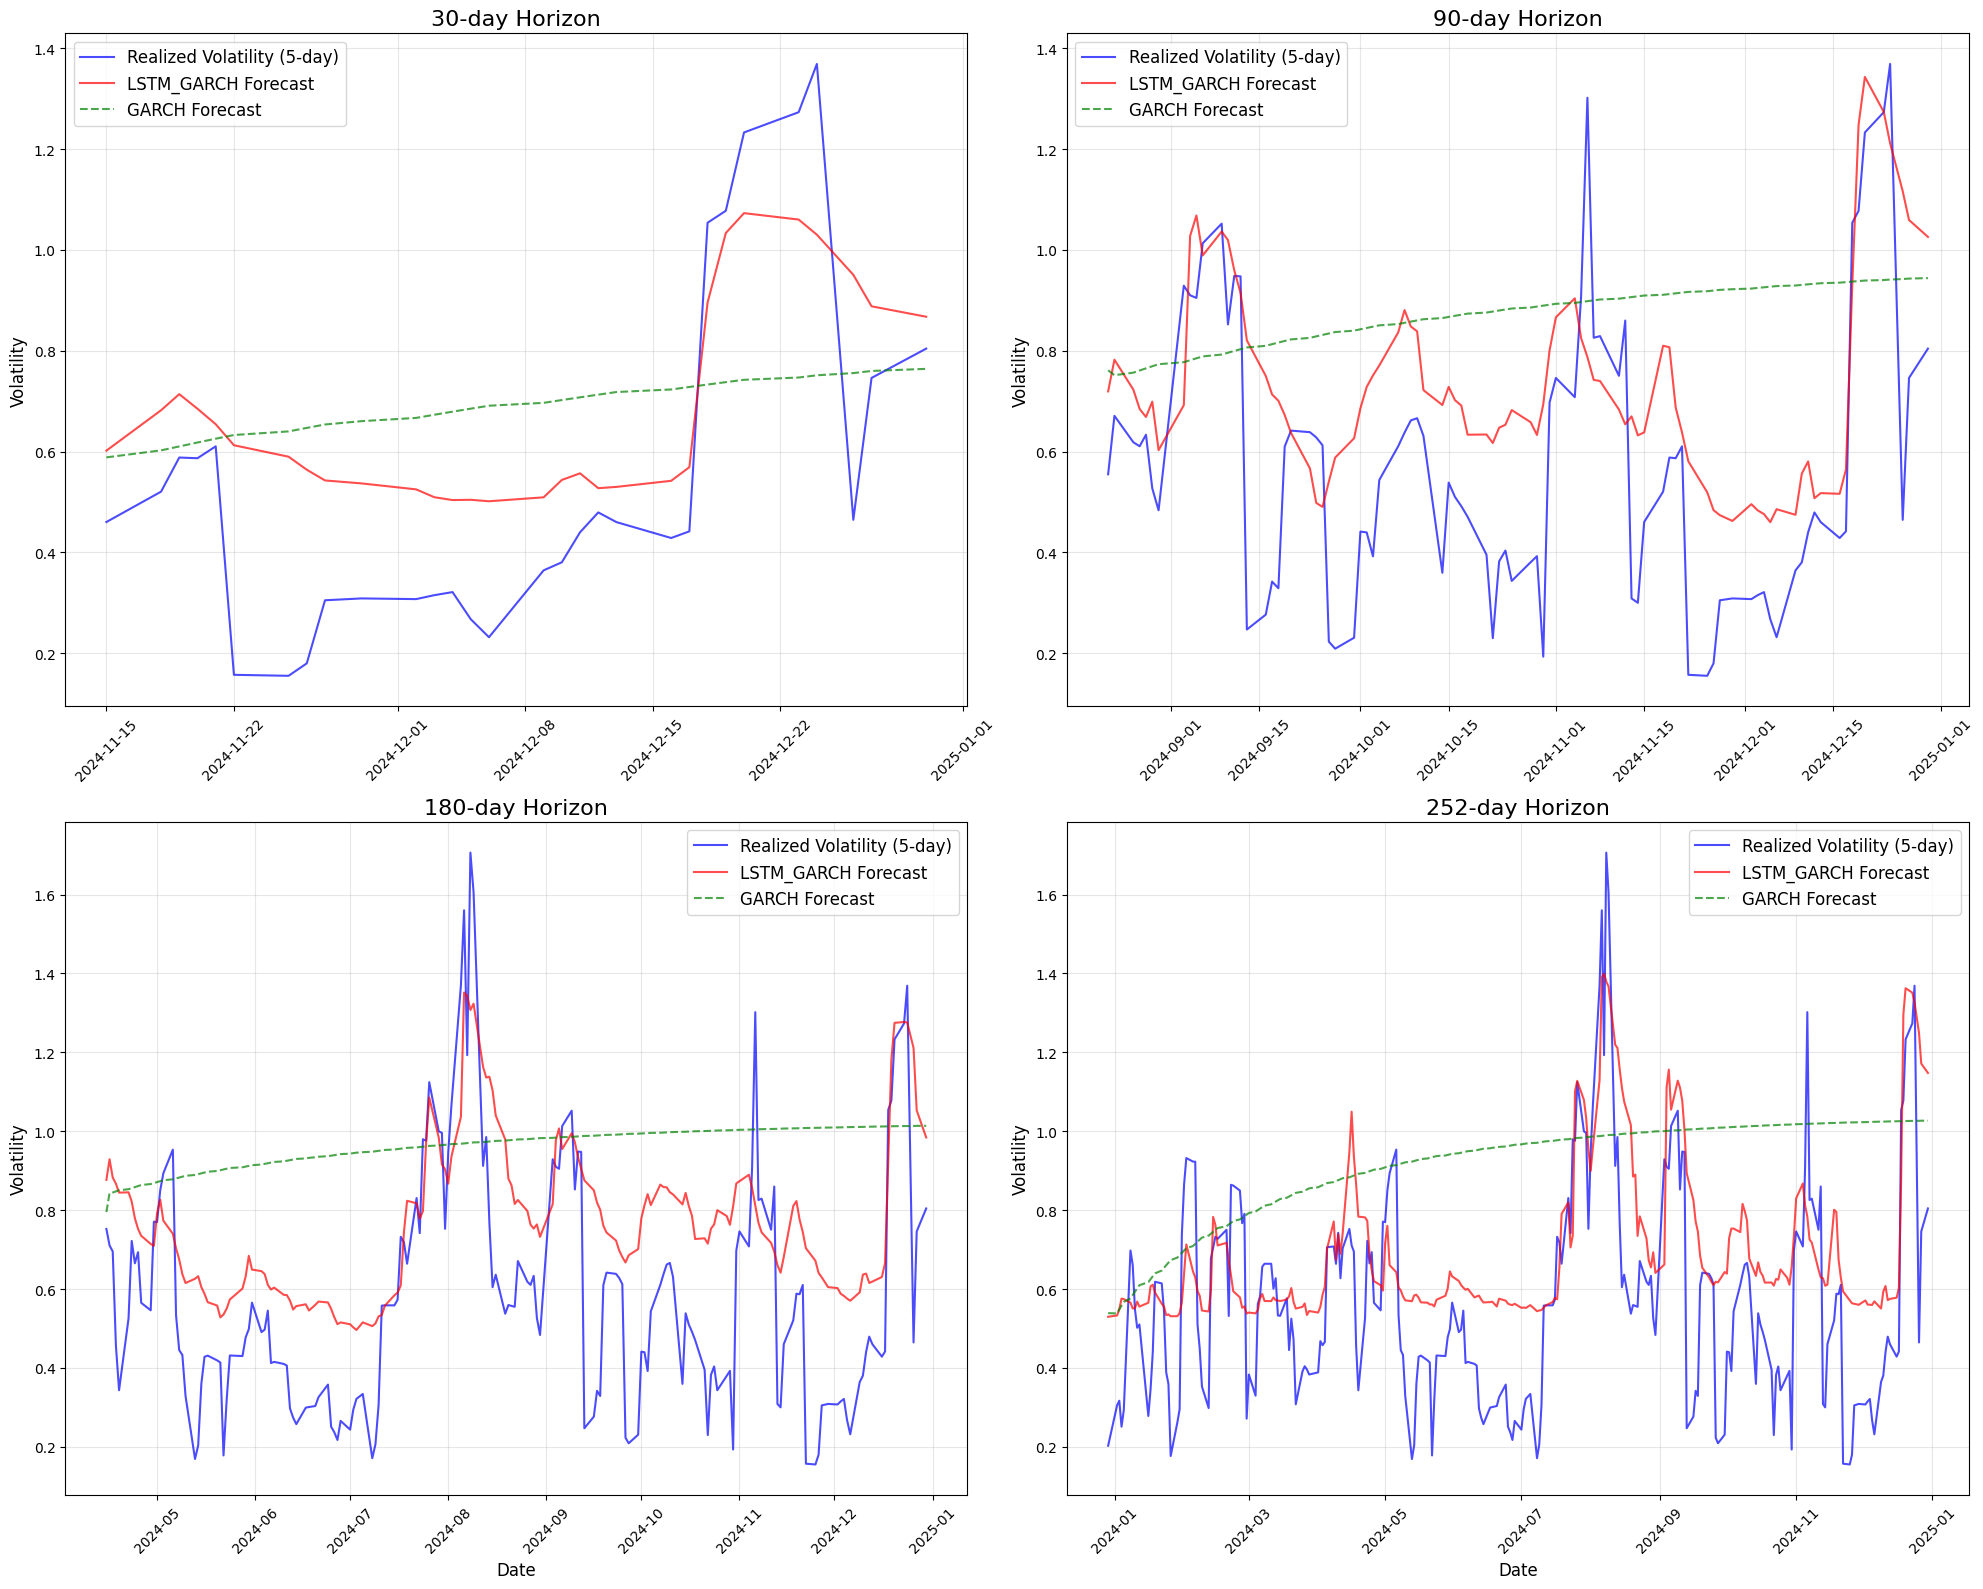

In [122]:
# Create figure for LSTM forecasts comparison
plt.figure(figsize=(16, 10))

# Get realized volatility
plt.plot(realized_vol_5d.index[-252:], realized_vol_5d.iloc[-252:], 
         label='Realized Volatility (5-day)', 
         color='blue', 
         alpha=0.7)

# Plot LSTM forecasts for each horizon with different colors
colors = ['red', 'green', 'purple', 'orange']
for horizon, color in zip(test_horizon, colors):
    # Format forecast data properly
    forecast_data = results[f'LSTM_GARCH{horizon}']['forecasts'].flatten()
    
    # Get appropriate index for this forecast horizon
    forecast_index = df.index[-horizon:]
    
    # Create a Series with forecasts
    forecast_series = pd.Series(forecast_data, index=forecast_index)
    
    # Plot the forecast
    plt.plot(forecast_index, 
             forecast_series, 
             label=f'LSTM Forecast ({horizon}-day)', 
             color=color, 
             alpha=0.7)

# Customize plot
plt.title('S&P500 Realized Volatility vs LSTM-GARCH Forecasts', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Create a figure with 4 subplots to compare LSTM-GARCH vs GARCH
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

# For each horizon, plot both models against realized volatility
for i, horizon in enumerate(test_horizon):
    ax = axes[i]
    
    # Get forecast index
    forecast_index = df.index[-horizon:]
    
    # Get LSTM forecast for this horizon
    lstm_forecast = pd.Series(
        results[f'LSTM_GARCH{horizon}']['forecasts'].flatten(), 
        index=forecast_index
    )
    
    # Get GARCH forecast for this horizon
    garch_forecast = garch_forecasts[horizon]['forecast']
    
    # Find common dates between forecasts and realized volatility
    common_dates = forecast_index.intersection(realized_vol_5d.index)
    
    # Plot realized volatility
    ax.plot(common_dates, realized_vol_5d.loc[common_dates], 
            label='Realized Volatility (5-day)', 
            color='blue', 
            alpha=0.7)
    
    # Plot LSTM forecast
    ax.plot(lstm_forecast.index, lstm_forecast, 
            label='LSTM_GARCH Forecast', 
            color='red', 
            linestyle='-', 
            alpha=0.7)
    
    # Plot GARCH forecast
    ax.plot(garch_forecast.index, garch_forecast, 
            label='GARCH Forecast', 
            color='green', 
            linestyle='--', 
            alpha=0.7)
    
    # Add title and labels
    ax.set_title(f'{horizon}-day Horizon', fontsize=16)
    ax.set_ylabel('Volatility', fontsize=12)
    if i >= 2:  # Only add xlabel for bottom row plots
        ax.set_xlabel('Date', fontsize=12)
    
    # Add legend and grid
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Comparison

In [125]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

def calculate_metrics(y_true, y_pred):
    """Calculate various performance metrics."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape
    }

# Initialize lists to store results
metrics_data = []

for horizon in test_horizon:
    # Get the actual values for this horizon
    actual_values = realized_vol_5d[-horizon:]
    
    # Get forecasts for each model
    garch_forecast = garch_forecasts[horizon]['forecast']
    lstm_forecast = pd.Series(results[f'LSTM_{horizon}']['forecasts'].flatten(), index=garch_forecast.index)
    lstm_garch_forecast = pd.Series(results[f'LSTM_GARCH{horizon}']['forecasts'].flatten(), index=garch_forecast.index)
    
    # Calculate metrics for each model
    garch_metrics = calculate_metrics(actual_values, garch_forecast)
    lstm_metrics = calculate_metrics(actual_values, lstm_forecast)
    lstm_garch_metrics = calculate_metrics(actual_values, lstm_garch_forecast)
    
    # Add results to the list
    metrics_data.extend([
        {'Horizon': horizon, 'Model': 'GARCH', **garch_metrics},
        {'Horizon': horizon, 'Model': 'LSTM', **lstm_metrics},
        {'Horizon': horizon, 'Model': 'LSTM-GARCH', **lstm_garch_metrics}
    ])

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Pivot the DataFrame for better presentation
pivot_df = metrics_df.pivot_table(
    index='Model',
    columns='Horizon',
    values=['RMSE', 'MAE', 'MSE', 'MAPE']
).round(4)



In [126]:
pivot_df

MAE                             MAPE                      \
Horizon        30      90      180     252      30        90        180   
Model                                                                     
GARCH       0.2997  0.3662  0.4297  0.3876  86.1669  103.5895  119.3204   
LSTM        0.1938  0.2251  0.1977  0.1679  61.4580   61.7592   51.9936   
LSTM-GARCH  0.1933  0.2027  0.2283  0.1899  60.9928   55.4480   62.1553   

                         MSE                            RMSE                  \
Horizon          252     30      90      180     252     30      90      180   
Model                                                                          
GARCH       105.7179  0.1166  0.1733  0.2360  0.2028  0.3415  0.4163  0.4858   
LSTM         38.3107  0.0584  0.0726  0.0565  0.0502  0.2416  0.2694  0.2377   
LSTM-GARCH   50.1020  0.0514  0.0588  0.0728  0.0530  0.2268  0.2425  0.2698   

                    
Horizon        252  
Model               
GARCH       0.4503  
LSTM        0.2242  
LSTM-GARCH  0.2302

Model Comparison Results Analysis
The table compares three forecasting models (GARCH, LSTM, and LSTM-GARCH) across different time horizons (30, 90, 180, and 252 days) using four error metrics.

GARCH Model Performance
Consistently shows the highest error rates across all metrics and horizons
MAE ranges from 0.2997 to 0.4297, with worst performance at the 180-day horizon
Very high MAPE values (86.17% to 119.32%), indicating poor percentage accuracy
Highest MSE and RMSE values among all models

LSTM Model Performance
Significantly outperforms traditional GARCH across all metrics
MAE values are 30-60% lower than GARCH, ranging from 0.1679 to 0.2251
MAPE shows substantial improvement (38.31% to 61.76%)
Performs particularly well at longer horizons (180 and 252 days)

LSTM-GARCH Hybrid Performance
Shows competitive or slightly better performance than LSTM at shorter horizons
For 30-day forecasts, slightly outperforms LSTM across all metrics
For 90-day forecasts, shows notably better results than LSTM (MAPE of 55.45% vs 61.76%)
At longer horizons, performs slightly worse than LSTM but still much better than GARCH alone

Summary:
Both neural network-based models (LSTM and LSTM-GARCH) substantially outperform the traditional GARCH model
The hybrid LSTM-GARCH appears more effective for shorter-term forecasting (30-90 days)
The standalone LSTM shows stronger performance for longer-term forecasting (180-252 days)
Interestingly, forecast accuracy doesn't always deteriorate with longer horizons - the 252-day forecasts often show better performance than 180-day forecasts
The results demonstrate the value of incorporating machine learning techniques into financial forecasting models, with the hybrid approach offering targeted benefits depending on the forecast horizon.

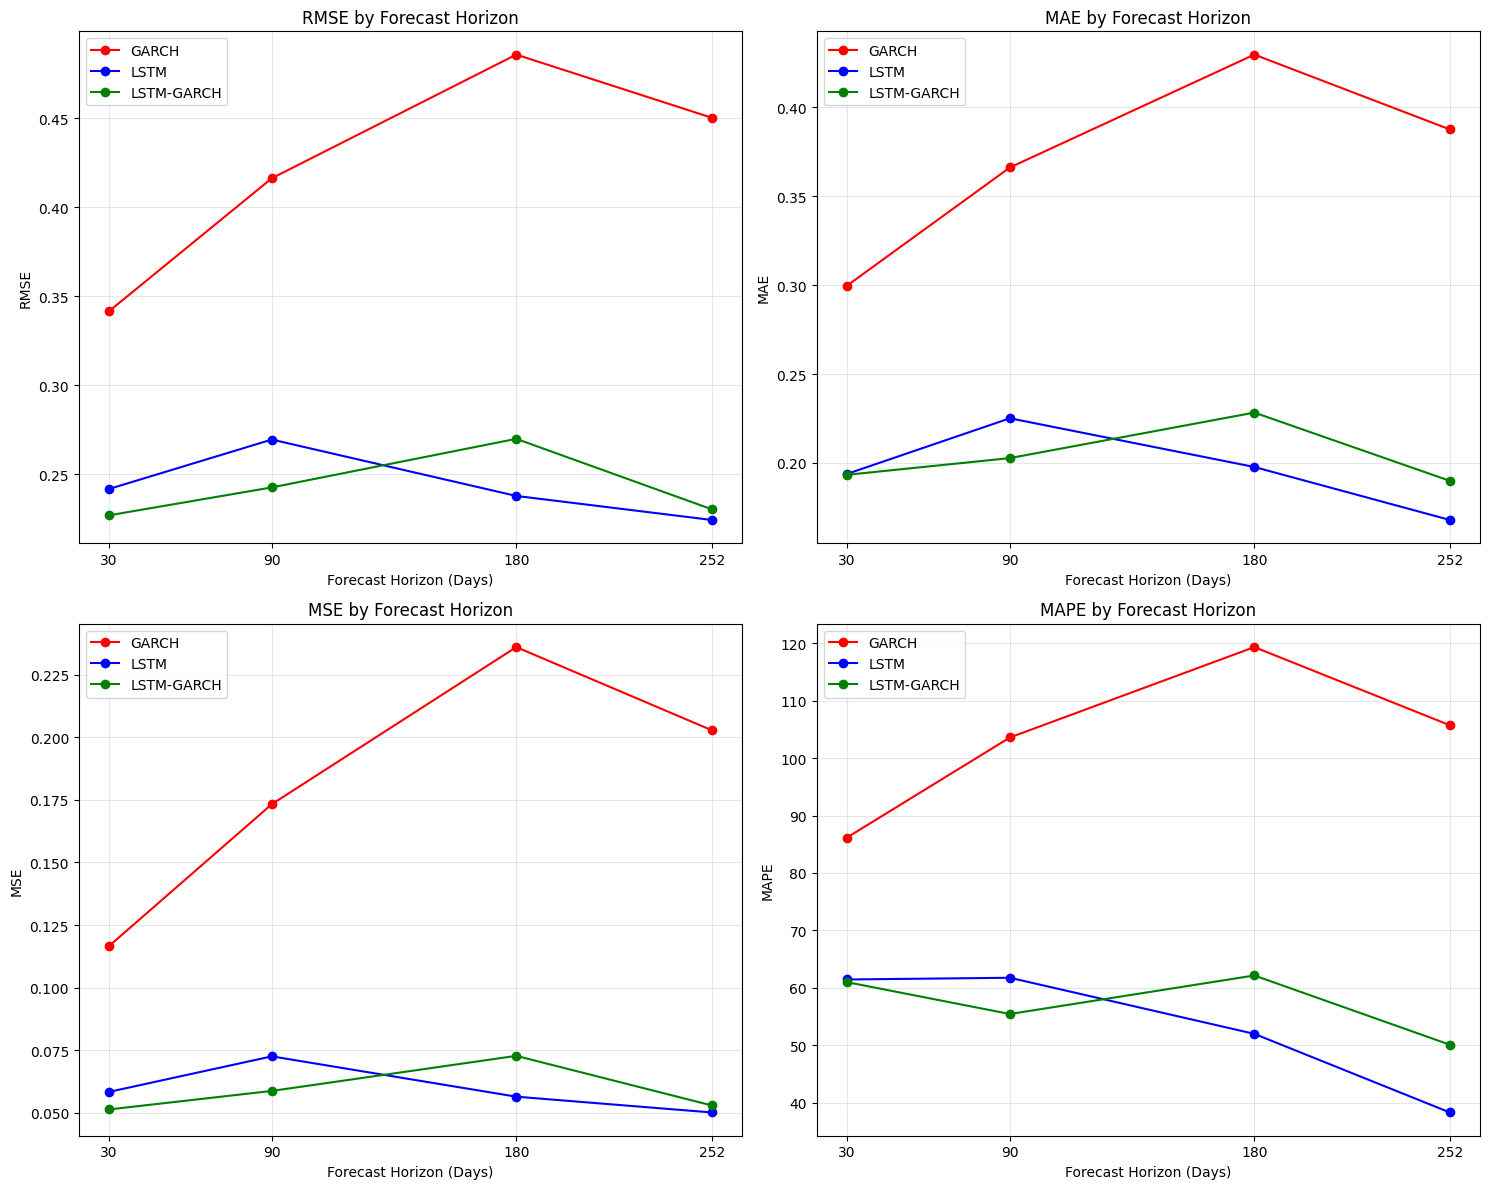

In [130]:
# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

metrics = ['RMSE', 'MAE', 'MSE', 'MAPE']
colors = {'GARCH': 'red', 'LSTM': 'blue', 'LSTM-GARCH': 'green'}

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # Plot each model
    for model in ['GARCH', 'LSTM', 'LSTM-GARCH']:
        # Extract data for this model and metric
        horizons = test_horizon
        values = pivot_df.loc[model, (metric, horizons)].values
        
        # Plot line
        ax.plot(horizons, values, marker='o', label=model, color=colors[model])
    
    # Customize plot
    ax.set_title(f'{metric} by Forecast Horizon', fontsize=12)
    ax.set_xlabel('Forecast Horizon (Days)', fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Set x-axis ticks to match horizons
    ax.set_xticks(horizons)

plt.tight_layout()
plt.show()

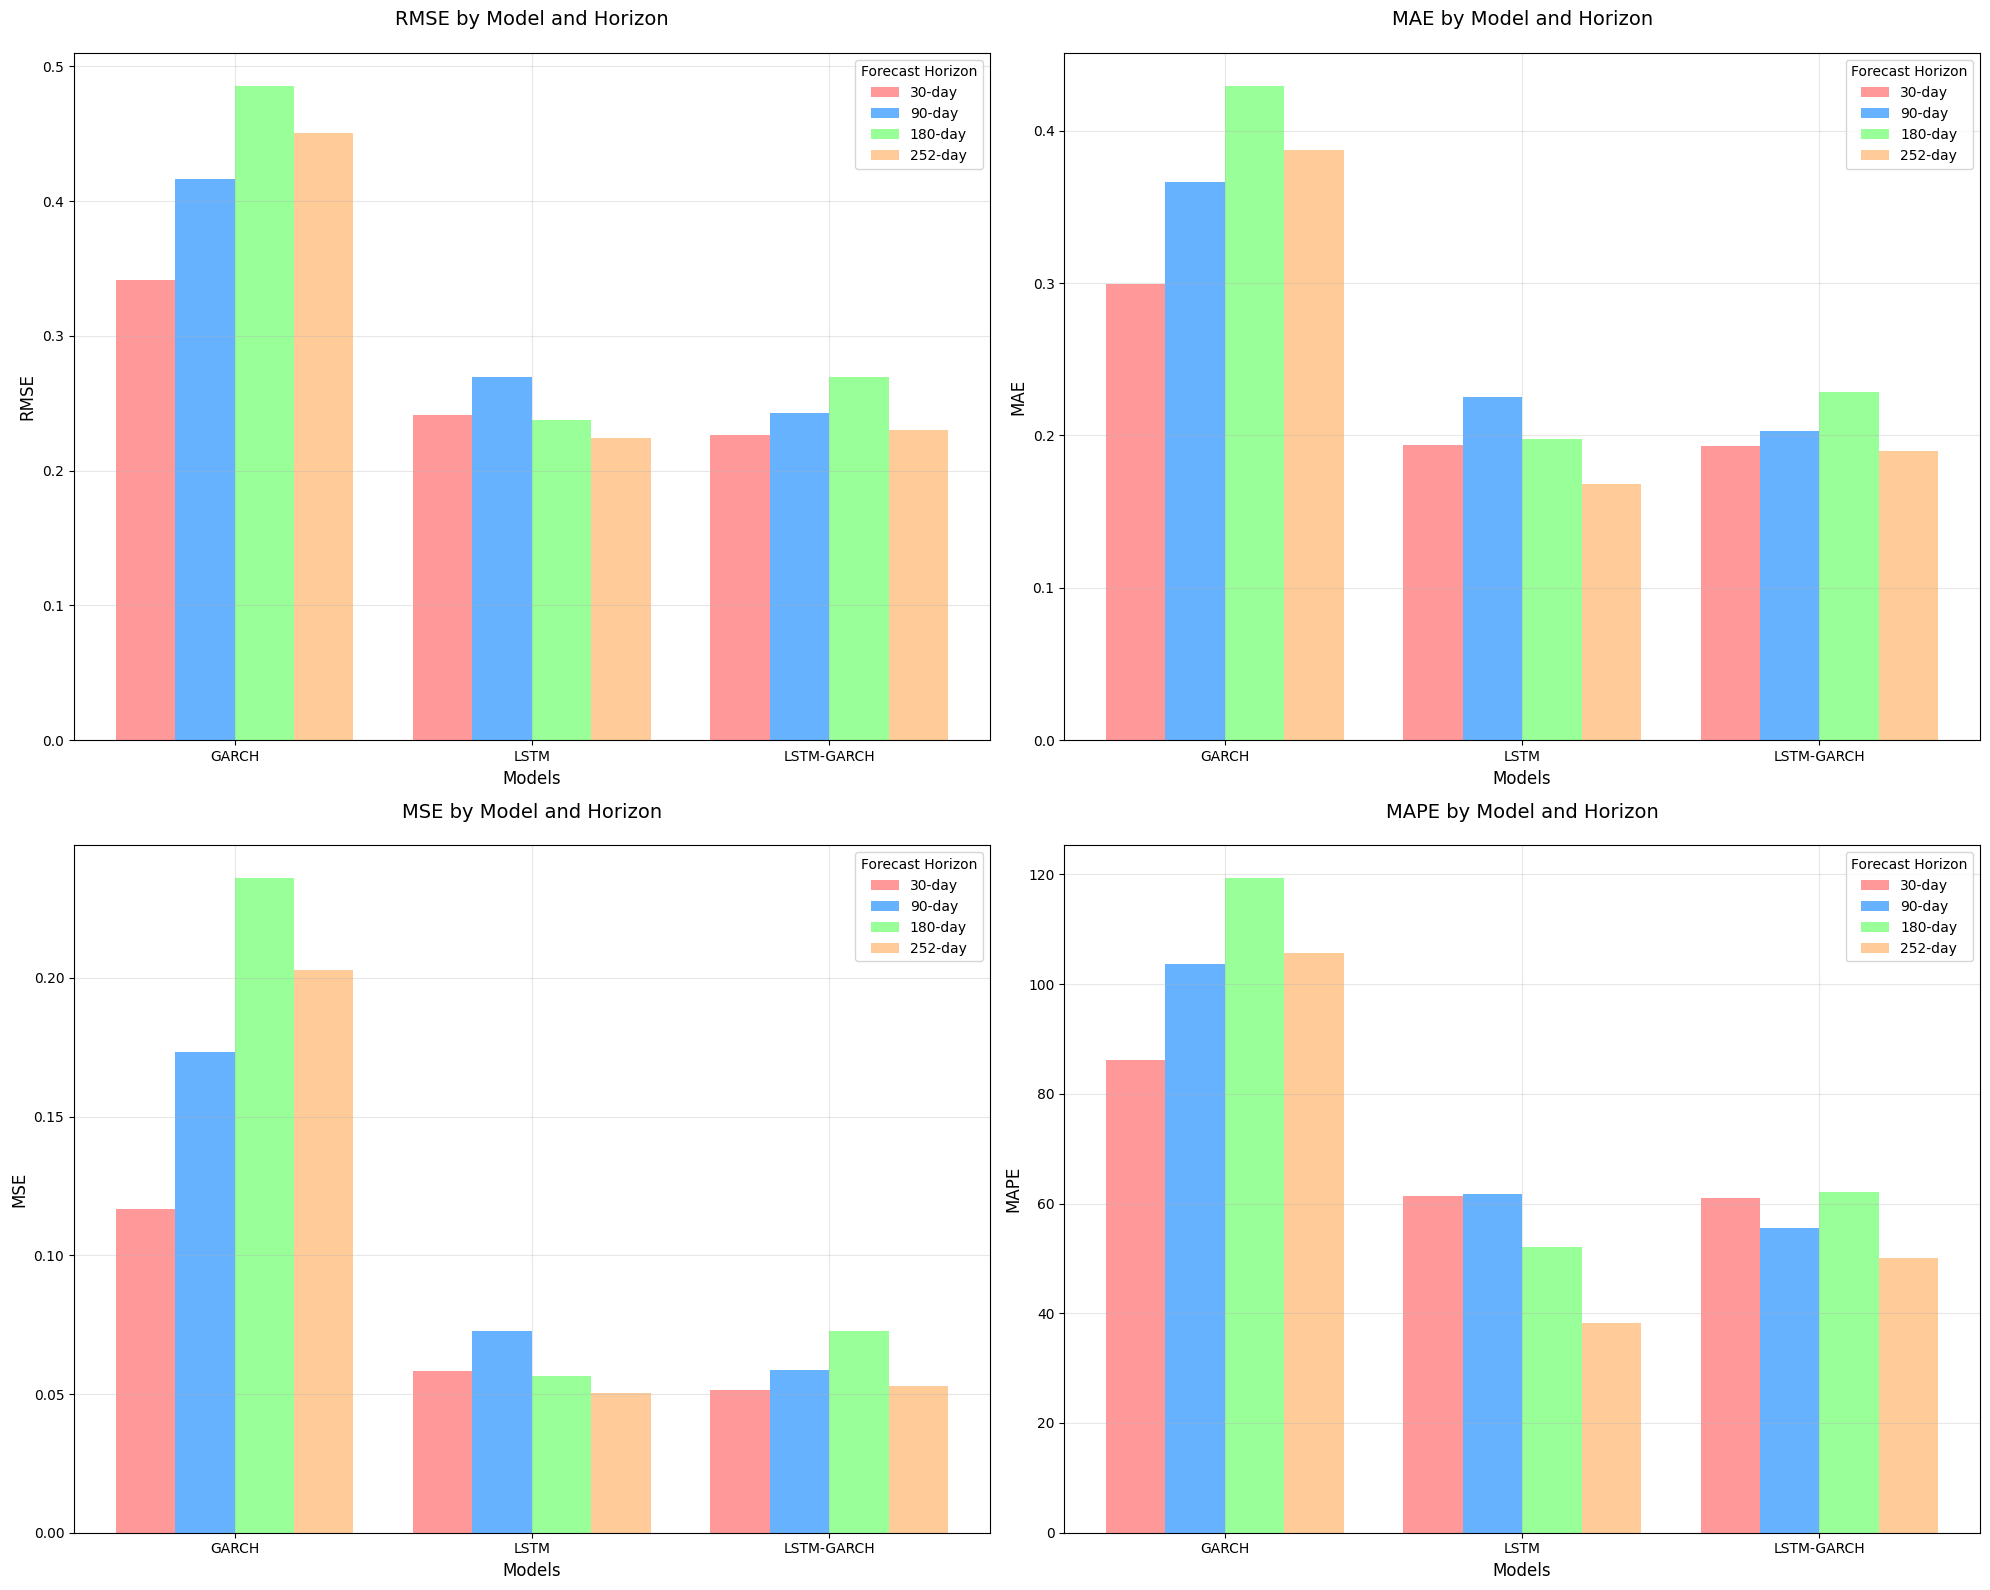

In [136]:
# Create a figure with 4 subplots (one for each metric)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

# Define metrics and colors
metrics = ['RMSE', 'MAE', 'MSE', 'MAPE']
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']  # Colors for different horizons
models = ['GARCH', 'LSTM', 'LSTM-GARCH']
horizons = [30, 90, 180, 252]

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    x = np.arange(len(models))
    width = 0.2  # Width of bars
    
    # Plot bars for each horizon
    for j, horizon in enumerate(horizons):
        values = [pivot_df.loc[model, (metric, horizon)] for model in models]
        ax.bar(x + (j-1.5)*width, values, width, label=f'{horizon}-day', color=colors[j], alpha=1)
    
    # Customize plot
    ax.set_title(f'{metric} by Model and Horizon', fontsize=14, pad=20)
    ax.set_xlabel('Models', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.grid(True, alpha=0.3)
    ax.legend(title='Forecast Horizon')
    
  

plt.tight_layout()
plt.show()

# VAR

In [129]:
def calculate_var(forecasts, confidence_levels=[0.95, 0.99]):
    """
    Calculate Value at Risk (VaR) for given forecasts at specified confidence levels
    
    Parameters:
    -----------
    forecasts : array-like
        Array of forecast values
    confidence_levels : list
        List of confidence levels (e.g., [0.95, 0.99])
        
    Returns:
    --------
    dict : Dictionary with confidence levels as keys and VaR values as values
    """
    # Convert forecasts to numpy array if it's not already
    if isinstance(forecasts, pd.Series):
        forecasts = forecasts.values
        
    # Calculate VaR for each confidence level
    vars = {}
    for level in confidence_levels:
        vars[level] = np.percentile(forecasts, (1 - level) * 100)
    return vars

# Dictionary to store all forecasts
all_forecasts = {}

# For each horizon
for horizon in test_horizon:
    # Get GARCH forecasts
    garch_forecast = garch_forecasts[horizon]['forecast']
    
    # Get LSTM forecasts
    lstm_forecast = pd.Series(
        results[f'LSTM_{horizon}']['forecasts'].flatten(),
        index=garch_forecast.index
    )
    
    # Get LSTM-GARCH forecasts
    lstm_garch_forecast = pd.Series(
        results[f'LSTM_GARCH{horizon}']['forecasts'].flatten(),
        index=garch_forecast.index
    )
    
    # Store forecasts
    all_forecasts[f'GARCH_{horizon}'] = garch_forecast
    all_forecasts[f'LSTM_{horizon}'] = lstm_forecast
    all_forecasts[f'LSTM_GARCH_{horizon}'] = lstm_garch_forecast

# Calculate VaR for each set of forecasts
var_results = []
confidence_levels = [0.95, 0.99]

for name, forecasts in all_forecasts.items():
    model_type, horizon = name.rsplit('_', 1)  # Use rsplit to split from right
    vars = calculate_var(forecasts, confidence_levels)
    
    var_results.append({
        'Model': model_type,
        'Horizon': horizon,
        'VaR_95': vars[0.95],
        'VaR_99': vars[0.99],
        'Mean': forecasts.mean(),
        'Std': forecasts.std()
    })

# Create DataFrame
var_df = pd.DataFrame(var_results)

# Sort by Model and Horizon
var_df['Horizon'] = var_df['Horizon'].astype(int)
var_df = var_df.sort_values(['Model', 'Horizon'])

# Format numbers
var_df[['VaR_95', 'VaR_99', 'Mean', 'Std']] = var_df[['VaR_95', 'VaR_99', 'Mean', 'Std']].round(4)

# Display results
print("\nValue at Risk (VaR) Comparison:")
print(var_df)

# Create a pivot table for easier comparison
pivot_var = var_df.pivot_table(
    index='Model',
    columns='Horizon',
    values=['VaR_95', 'VaR_99', 'Mean', 'Std']
).round(4)

pivot_var


Value at Risk (VaR) Comparison:
         Model  Horizon  VaR_95  VaR_99    Mean     Std
0        GARCH       30  0.6060  0.5926  0.6885  0.0516
3        GARCH       90  0.7670  0.7561  0.8708  0.0559
6        GARCH      180  0.8636  0.8444  0.9617  0.0486
9        GARCH      252  0.6366  0.5534  0.9153  0.1244
1         LSTM       30  0.5280  0.5210  0.7223  0.2918
4         LSTM       90  0.4890  0.4768  0.7381  0.1546
7         LSTM      180  0.4576  0.4236  0.7161  0.1986
10        LSTM      252  0.3460  0.3229  0.6614  0.3090
2   LSTM_GARCH       30  0.5041  0.5022  0.6769  0.1952
5   LSTM_GARCH       90  0.4794  0.4622  0.7295  0.1971
8   LSTM_GARCH      180  0.5286  0.5054  0.7677  0.1903
11  LSTM_GARCH      252  0.5435  0.5321  0.7008  0.2032


Mean                             Std                          \
Horizon        30      90      180     252     30      90      180     252   
Model                                                                        
GARCH       0.6885  0.8708  0.9617  0.9153  0.0516  0.0559  0.0486  0.1244   
LSTM        0.7223  0.7381  0.7161  0.6614  0.2918  0.1546  0.1986  0.3090   
LSTM_GARCH  0.6769  0.7295  0.7677  0.7008  0.1952  0.1971  0.1903  0.2032   

            VaR_95                          VaR_99                          
Horizon        30      90      180     252     30      90      180     252  
Model                                                                       
GARCH       0.6060  0.7670  0.8636  0.6366  0.5926  0.7561  0.8444  0.5534  
LSTM        0.5280  0.4890  0.4576  0.3460  0.5210  0.4768  0.4236  0.3229  
LSTM_GARCH  0.5041  0.4794  0.5286  0.5435  0.5022  0.4622  0.5054  0.5321

GARCH Model:

Mean Forecasts: Highest among all models (0.6885-0.9617), peaking at the 180-day horizon

Volatility (Std): Relatively stable and low at shorter horizons (0.0516-0.0559) but spikes significantly at 252 days (0.1244)

Risk Estimates: Produces the most conservative (highest) VaR values

VaR Pattern: Both 95% and 99% VaR increase up to 180 days, then drop sharply at 252 days

LSTM Model:

Mean Forecasts: More moderate values (0.6614-0.7381) with a gradual downward trend as horizon extends

Volatility (Std): Highest at short (30-day) and long (252-day) horizons

Risk Estimates: Consistently produces the lowest VaR values at both 95% and 99% levels

VaR Pattern: Shows a consistent downward trend as the forecast horizon increases

LSTM-GARCH Hybrid

Mean Forecasts: Shows an arc pattern, peaking at 180 days (0.7677)

Volatility (Std): Most consistent across all horizons (0.1952-0.2032)

Risk Estimates: VaR values generally fall between the other two models

VaR Pattern: U-shaped for both 95% and 99% levels, with minimum risk at 90 days

Risk Management Implications
Model Selection Trade-offs:

GARCH provides the most conservative risk estimates (higher VaR)

LSTM suggests significantly lower potential losses, especially at longer horizons

LSTM-GARCH offers a balanced middle ground with more consistent volatility estimates

Horizon Considerations:

Short horizons (30 days): LSTM-GARCH offers the lowest risk estimates

Medium horizons (90 days): Both neural network models show similar, lower risk

Longer horizons (180-252 days): LSTM consistently estimates lower potential losses



LSTM-GARCH provides the most stable volatility estimates across timeframes

GARCH shows dramatic risk reduction at the 252-day mark

LSTM suggests progressively decreasing risk over longer horizons
